# TP 2-3 : Branch-and-bound applied to a knapsack problem

## Initialisation (à faire une seule fois)

In [1]:
import Pkg;
Pkg.add("GraphRecipes");
Pkg.add("Plots");
using GraphRecipes, Plots #only used to visualize the search tree at the end of the branch-and-bound

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
Precompiling project...
  ✓ TestOptinum
  1 dependency successfully precompiled in 7 seconds (270 already precompiled)
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
Precompiling project...
  ✓ TestOptinum
  1 dependency successfully precompiled in 4 seconds (270 already precompiled)


## Récupération des données

In [2]:
"""Open and read a KnapFile.

Args: \\
    - filename (String): the name of the file to read.

Returns: \\
    - price (Vector{Integer}): prices of items to put in the KnapSack. \\
    - weight (Vector{Integer}): weights of items to put in the KnapSack. \\
    - capacity (Integer): the maximum capacity of the KnapSack.
"""
function readKnapInstance(filename)
    price = []
    weight = []
    capacity = -1
    open(filename) do f
        for i = 1:3
            tok = split(readline(f))
            if (tok[1] == "ListPrices=")
                for i = 2:(length(tok)-1)
                    push!(price, parse(Int64, tok[i]))
                end
            elseif (tok[1] == "ListWeights=")
                for i = 2:(length(tok)-1)
                    push!(weight, parse(Int64, tok[i]))
                end
            elseif (tok[1] == "Capacity=")
                capacity = parse(Int64, tok[2])
            else
                println("Unknown read :", tok)
            end
        end
    end
    return price, weight, capacity
end

readKnapInstance

In [3]:
# on teste de lire tous les fichiers .opb
for (root, dirs, files) in walkdir("data")
    for file in files
        if endswith(file, ".opb")
            readKnapInstance(root * "/" * file)
        end
    end
end

## Procédure d'application des tests de sondabilités TA, TO et TR pour le cas de la relaxation linéaire

In [4]:
"""Test if a node should be pruned.

Args: \\
    - x (Vector{Integer}): the node to be tested. \\
    - price (Vector{Integer}): prices of items to put in the KnapSack. \\
    - weight (Vector{Integer}): weights of items to put in the KnapSack. \\
    - capacity (Integer): the maximum capacity of the KnapSack. \\
    - BestProfit (Integer): the current BestProfit value. \\
    - Bestsol (Integer): the current BestSol values. \\
    - affich (Bool): determine if the function should print to stdout.

Returns: \\
    - TA (Bool): true if the node is feasible. \\
    - TO (Bool): true if the node is optimal. \\
    - TR (Bool): true if the node is resolvable. \\
    - BestProfit (Integer): the updated value of BestProfit. \\
    - Bestsol (Vector{Integer}): the updated values of BestSol.
"""
function TestsSondabilite_relaxlin(x, price, weight, capacity, BestProfit, Bestsol, affich)
    TA, TO, TR = false, false, false

    if (!Constraints(x, weight, capacity)) # Test de faisabilite
        TA = true
        if affich
            println("TA\n")
        end

    elseif (Objective(x, price) <= BestProfit) # Test d'optimalite
        TO = true
        if affich
            println("TO\n")
        end

    elseif (AllDef(x)) # Test de resolution
        TR = true
        if affich
            println("TR : solution ", " de profit ", Objective(x, price), "\n")
        end
        if (Objective(x, price) >= BestProfit) # Le profit de la solution trouvée est meilleur que les autres
            if affich
                println("\t-> Cette solution a un meilleur profit.\n")
            end
            # On remplace la solution et le profit par les nouvelles valeurs
            Bestsol = x
            BestProfit = Objective(x, price)
        else
            if affich
                println("\t-> Cette solution est moins bonne.\n")
            end
        end

    elseif affich
        println("non sondable\n")
    end

    return TA, TO, TR, Bestsol, BestProfit
end

TestsSondabilite_relaxlin

## Procédure de séparation et stratégie d'exploration permettant de se placer au prochain noeud à traiter

In [5]:
"""Split a node in two.

Args: \\
    - price (Vector{Integer}): prices of items to put in the KnapSack. \\
    - listvars (Vector{Vector{Integer}}): the current values of listvars. \\
    - listvals (Vector{Integer}): the current values of listvals.

Returns: \\
    - listvars (Vector{Vector{Integer}}): the updated values of listvars. \\
    - listvals (Vector{Integer}): the updated values of listvals.
"""
function SeparerNoeud_relaxlin(price, listvars, listvals)
    # Le noeud est non-sondable. Appliquer le critère de séparation pour le séparer en sous-noeuds 

    # Cas du noeud le plus à gauche

    # On sépare le noeud actuel en 2 sous-noeuds
    predX = pop!(listvars)
    nextX0 = copy(predX)
    nextX1 = copy(predX)

    # On initialise leurs valeurs à zéro
    val0 = 0
    val1 = 0

    # On fixe la nouvelle variable des deux sous-noeuds
    n = length(predX)
    for i = 1:n
        if predX[i] == -1
            # L'un a zéro
            nextX0[i] = 0
            # L'autre a un
            nextX1[i] = 1

            # On calcule leurs valeurs
            val0 = Objective(nextX0, price)
            val1 = Objective(nextX1, price)
            break
        end
    end

    # On ajoute les sous-noeuds a la pile des noeuds a explorer
    push!(listvars, nextX0)
    push!(listvars, nextX1)

    # On ajoute aussi leurs valeurs
    push!(listvals, val0)
    push!(listvals, val1)

    return listvars, listvals
end

SeparerNoeud_relaxlin

In [13]:
"""Pop node fom the list to explore another node.

Args: \\
    - price (Vector{Integer}): prices of items to put in the KnapSack. \\
    - listvars (Vector{Vector{Integer}}): the current values of listvars. \\
    - listvals (Vector{Integer}): the current values of listvals.

Returns: \\
    - listvars (Vector{Vector{Integer}}): the updated values of listvars. \\
    - listvals (Vector{Integer}): the updated values of listvals. \\
    - stop (Bool): true if the tree search is finished.
"""
function ExplorerAutreNoeud_relaxlin(listvars, listvals)
    # Le noeud est sondable, on l'enlève de la pile des noeuds à sonder

    stop = false
    if (length(listvars) > 1)
        # On passe au noeud suivant
        var = pop!(listvars)
        val = pop!(listvals)
    else
        # Il n'y a pas d'autre noeud
        stop = true
    end

    return listvars, listvals, stop
end

ExplorerAutreNoeud_relaxlin

## Fonctions décrivant l'objectif et les contraintes

In [14]:
# Fonction objectif que l'on souhaite maximiser/minimiser (évalué dans le meilleur des cas)
Objective(x, price) =
    sum(
        if x[i] < 0
            price[i]
        else
            price[i] * x[i]
        end
        for i = 1:length(x)
    )

# Fonction permettant de vérfier toutes les contraintes du modèle (dans le meilleur des cas)
Constraints(x, weight, capacity) =
    sum(
        if x[i] < 0
            0
        else
            weight[i] * x[i]
        end
        for i = 1:length(x)
    ) <= capacity

# Fonction qui nous dis si toutes les variables de x sont fixées
function AllDef(x)
    for i = 1:length(x)
        if x[i] < 0
            return false
        end
    end
    return true
end

AllDef (generic function with 1 method)

## Résolution du problème KnapSack

In [15]:
"""Solve the KnapSack problem for the data contained in `filename`.

Args: \\
    - filename (String): the name of the file to read.

Returns: \\
    - trParentnodes (Vector{Integer}): the parents nodes, to plot the tree.
    - trChildnodes (Vector{Integer}): the child nodes, to plot the tree.
    - trNamenodes (Vector{Integer}): the name of the nodes, to plot the tree.
"""
function SolveKnapInstance(filename)

    stop = false
    affich = false

    # Extraction des données
    price, weight, capacity = readKnapInstance(filename)

    if affich
        println("Capacity : ", capacity, " | Number of objects : ", length(price), "\n")
    end

    # Pour dessiner le graph
    trParentnodes = Int64[]
    trChildnodes = Int64[]
    trNamenodes = []

    # Liste des variable pour naviguer de noeuds en noeuds
    listvars = []
    listvals = []
    listnodes = []

    # La meilleur solution et sa valeur
    BestProfit = -1
    Bestsol = []

    # Compter le nombre de noeud explorés
    current_node_number = 0

    # On ajoute le premier noeud à explorer (la racine)
    push!(listvars, [-1 for p in price])
    push!(listvals, Objective(last(listvars), price))
    push!(listnodes, 1)
    push!(trNamenodes, 0)
    newnodeid = 2

    while (!stop)

        # Le noeud actuel
        x = last(listvars)

        if affich && current_node_number % 10000 == 0
            println("----------\nNode n°", current_node_number, " :\n")
            println("Previous Solution memorized ", " with bestprofit ", BestProfit, "\n")
        end

        # Test de sondabilité du noeud actuel
        #   -> On mets a jour la solution et sa valeur si besoin
        TA, TO, TR, Bestsol, BestProfit = TestsSondabilite_relaxlin(x, price, weight, capacity, BestProfit, Bestsol, affich)

        is_node_sondable = TA || TO || TR
        if (!is_node_sondable)
            # Le noeud n'est pas sondable, on le sépare en 2 sous-noeuds
            listvars, listvals = SeparerNoeud_relaxlin(price, listvars, listvals)

            curnode = pop!(listnodes)

            push!(trParentnodes, curnode)
            push!(trParentnodes, curnode)

            push!(listnodes, newnodeid + 1)
            push!(listnodes, newnodeid)

            push!(trChildnodes, newnodeid)
            push!(trChildnodes, newnodeid + 1)

            push!(trNamenodes, newnodeid - 1)
            push!(trNamenodes, newnodeid)

            newnodeid += 2

        else
            # Le noeud est sondable, on passe au noeud suivant
            listvars, listvals, stop = ExplorerAutreNoeud_relaxlin(listvars, listvals)

            pop!(listnodes)
        end

        current_node_number += 1
    end

    if affich
        println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x = ", Bestsol)
    end
    
    return trParentnodes, trChildnodes, trNamenodes
end

SolveKnapInstance

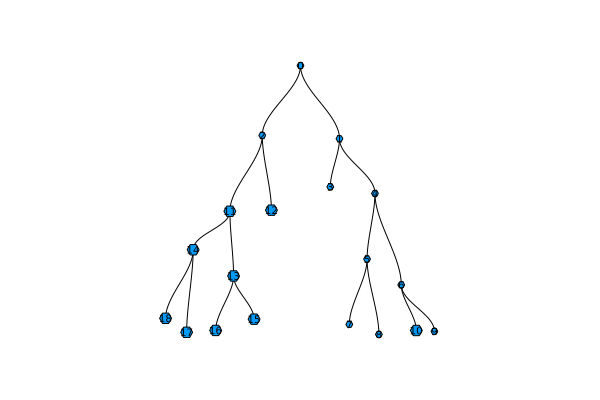

In [17]:
trParentnodes, trChildnodes, trNamenodes = SolveKnapInstance("data/test.opb")
graphplot(trParentnodes, trChildnodes, names = trNamenodes, method = :tree)

In [ ]:
# # on teste de résoudre tous les fichiers .opb
# for (root, dirs, files) in walkdir("data")
#     for file in files
#         if endswith(file, ".opb")
#             SolveKnapInstance(root * "/" * file)
#         end
#     end
# end